In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from DecoderTrans import DecoderTransformer
from tokenizer import CurriculumTokenizer
from torch.nn.utils.rnn import pad_sequence
%matplotlib inline

In [2]:
# Загружаем данные
df = pd.read_csv('сurriculum_data.csv')

# Разделение на тренировочный и тестовый наборы
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Определение классов для работы с данными
class ExpressionDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.tokenizer = CurriculumTokenizer()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        expression = row['expression']
        result = row['result']
        
        # Преобразуем метку, вычитая минимальное значение метки
        result -= self.df['result'].min()  # Это приводит все метки к диапазону от 0 до N-1
        
        encoded_expression = self.tokenizer.encode(expression)
        return encoded_expression, result


# Создание объектов Dataset
train_dataset = ExpressionDataset(train_df)
val_dataset = ExpressionDataset(val_df)


def collate_batch(batch):
    expressions, results = zip(*batch)
    
    # Преобразуем каждое выражение в тензор
    expressions = [torch.tensor(expr) for expr in expressions]
    
    # Получаем длину каждого выражения
    lengths = [len(expr) for expr in expressions]
    
    # Паддим выражения
    padded_expressions = pad_sequence(expressions, batch_first=True, padding_value=0)
    
    # Преобразуем результаты в тензор
    results_tensor = torch.LongTensor(results)  # Тензор меток
    
    return padded_expressions, lengths, results_tensor



# Создание DataLoader с использованием функции collate_batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_batch)

In [3]:
for batch in train_loader:
    print(batch)  # Печатаем весь batch, чтобы понять его структуру
    break  # Просто выводим первый батч, чтобы не выводить всё

def collate_batch(batch):
    expressions, results = zip(*batch)  # Разделяем выражения и результаты
    
    # Преобразуем каждое выражение в тензор
    expressions = [torch.tensor(expr) for expr in expressions]
    
    # Получаем длину каждого выражения
    lengths = [len(expr) for expr in expressions]  # Это можно использовать, если нужно
    
    # Паддим выражения
    padded_expressions = pad_sequence(expressions, batch_first=True, padding_value=0)
    
    # Преобразуем результаты в тензор
    results_tensor = torch.LongTensor(results)  # Тензор меток
    
    return padded_expressions, results_tensor

# Создаем DataLoader с collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)


(tensor([[ 1, 12, 12,  3,  6,  3, 11, 10, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1, 16, 19,  3,  4,  3, 14, 15,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1, 11, 14,  3,  6,  3, 16, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1, 18, 19,  3,  4,  3, 12, 14,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1,  3, 12, 18,  3,  4,  3, 17, 11,  3,  3,  6,  3,  3, 11, 19,  3,  5,
          3, 11, 19,  3,  2],
        [ 1, 15, 19,  3,  6,  3, 17, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1, 17, 11,  3,  6,  3, 18, 10,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1, 17, 10,  3,  4,  3, 16, 13,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],
        [ 1, 15, 15,  7, 12,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0],


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = DecoderTransformer(num_tokens=20, n_embd=128, num_layers=6, num_heads=8, num_classes=10).to(device)
num_classes = df['result'].max() - df['result'].min() + 1  # Подсчитываем количество классов
model = DecoderTransformer(num_tokens=20, n_embd=128, num_layers=6, num_heads=8, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [5]:
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Training")
    for inputs, targets in pbar:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Проверка минимальной и максимальной метки
        print(f"Минимальная метка: {targets.min()}")
        print(f"Максимальная метка: {targets.max()}")

        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Если задача классификации, то выход имеет размерность [batch_size, num_classes]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        pbar.set_postfix(loss=loss.item())
        
    accuracy = 100 * correct / total
    epoch_loss = total_loss / len(loader)
    return epoch_loss, accuracy


In [6]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(loader, desc="Evaluating")
        for inputs, lengths, targets in pbar:  # Теперь распаковываем три значения
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            pbar.set_postfix(loss=loss.item())
    accuracy = 100 * correct / total
    epoch_loss = total_loss / len(loader)
    return epoch_loss, accuracy


In [7]:
epochs = 10
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


Epoch 1/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 7
Максимальная метка: 9216
Минимальная метка: 5
Максимальная метка: 15792
Минимальная метка: 10
Максимальная метка: 13050
Минимальная метка: 0
Максимальная метка: 9801
Минимальная метка: 0
Максимальная метка: 14329
Минимальная метка: 4
Максимальная метка: 8918
Минимальная метка: 32
Максимальная метка: 8580
Минимальная метка: 0
Максимальная метка: 15386
Минимальная метка: 46
Максимальная метка: 6720
Минимальная метка: 39
Максимальная метка: 10164
Минимальная метка: 10
Максимальная метка: 8910
Минимальная метка: 1
Максимальная метка: 9409
Минимальная метка: 0
Максимальная метка: 10241
Минимальная метка: 1
Максимальная метка: 10725
Минимальная метка: 27
Максимальная метка: 11245
Минимальная метка: 10
Максимальная метка: 9409
Минимальная метка: 2
Максимальная метка: 9604
Минимальная метка: 10
Максимальная метка: 14400
Минимальная метка: 30
Максимальная метка: 8208
Минимальная метка: 4
Максимальная метка: 9604
Минимальная метка: 36
Максимальная метка: 9409
Минимальная мет

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 8.2174, Train Acc: 0.31%
Val Loss: 7.4155, Val Acc: 0.34%

Epoch 2/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 2
Максимальная метка: 11328
Минимальная метка: 0
Максимальная метка: 8649
Минимальная метка: 0
Максимальная метка: 6120
Минимальная метка: 5
Максимальная метка: 9882
Минимальная метка: 0
Максимальная метка: 6996
Минимальная метка: 21
Максимальная метка: 11100
Минимальная метка: 17
Максимальная метка: 11305
Минимальная метка: 53
Максимальная метка: 9025
Минимальная метка: 18
Максимальная метка: 14508
Минимальная метка: 9
Максимальная метка: 8640
Минимальная метка: 1
Максимальная метка: 10370
Минимальная метка: 15
Максимальная метка: 7921
Минимальная метка: 52
Максимальная метка: 10209
Минимальная метка: 0
Максимальная метка: 12672
Минимальная метка: 1
Максимальная метка: 14592
Минимальная метка: 4
Максимальная метка: 15386
Минимальная метка: 86
Максимальная метка: 9409
Минимальная метка: 0
Максимальная метка: 16020
Минимальная метка: 14
Максимальная метка: 8281
Минимальная метка: 3
Максимальная метка: 12125
Минимальная метка: 11
Максимальная метка: 9801
Минимальная ме

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.7717, Train Acc: 0.31%
Val Loss: 7.5864, Val Acc: 0.41%

Epoch 3/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 16
Максимальная метка: 8757
Минимальная метка: 1
Максимальная метка: 8464
Минимальная метка: 4
Максимальная метка: 9409
Минимальная метка: 3
Максимальная метка: 10836
Минимальная метка: 10
Максимальная метка: 10437
Минимальная метка: 16
Максимальная метка: 7744
Минимальная метка: 4
Максимальная метка: 9801
Минимальная метка: 29
Максимальная метка: 9409
Минимальная метка: 5
Максимальная метка: 8463
Минимальная метка: 0
Максимальная метка: 10725
Минимальная метка: 19
Максимальная метка: 14508
Минимальная метка: 37
Максимальная метка: 7519
Минимальная метка: 0
Максимальная метка: 11100
Минимальная метка: 1
Максимальная метка: 10816
Минимальная метка: 24
Максимальная метка: 7744
Минимальная метка: 1
Максимальная метка: 12144
Минимальная метка: 13
Максимальная метка: 8778
Минимальная метка: 1
Максимальная метка: 9604
Минимальная метка: 41
Максимальная метка: 9570
Минимальная метка: 9
Максимальная метка: 8649
Минимальная метка: 61
Максимальная метка: 11305
Минимальная метк

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.5967, Train Acc: 0.36%
Val Loss: 7.7437, Val Acc: 0.76%

Epoch 4/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 8
Максимальная метка: 9409
Минимальная метка: 0
Максимальная метка: 14508
Минимальная метка: 11
Максимальная метка: 14536
Минимальная метка: 4
Максимальная метка: 11100
Минимальная метка: 2
Максимальная метка: 9801
Минимальная метка: 0
Максимальная метка: 9801
Минимальная метка: 6
Максимальная метка: 9120
Минимальная метка: 32
Максимальная метка: 9801
Минимальная метка: 14
Максимальная метка: 9486
Минимальная метка: 1
Максимальная метка: 9025
Минимальная метка: 6
Максимальная метка: 7584
Минимальная метка: 17
Максимальная метка: 9800
Минимальная метка: 0
Максимальная метка: 8100
Минимальная метка: 4
Максимальная метка: 10368
Минимальная метка: 13
Максимальная метка: 7544
Минимальная метка: 0
Максимальная метка: 9604
Минимальная метка: 46
Максимальная метка: 13386
Минимальная метка: 9
Максимальная метка: 15486
Минимальная метка: 0
Максимальная метка: 6561
Минимальная метка: 12
Максимальная метка: 9025
Минимальная метка: 9
Максимальная метка: 16055
Минимальная метка: 1

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.5516, Train Acc: 0.38%
Val Loss: 7.7667, Val Acc: 0.48%

Epoch 5/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 24
Максимальная метка: 8064
Минимальная метка: 6
Максимальная метка: 9409
Минимальная метка: 13
Максимальная метка: 12402
Минимальная метка: 9
Максимальная метка: 11328
Минимальная метка: 0
Максимальная метка: 9801
Минимальная метка: 3
Максимальная метка: 8836
Минимальная метка: 9
Максимальная метка: 14329
Минимальная метка: 16
Максимальная метка: 8326
Минимальная метка: 6
Максимальная метка: 8649
Минимальная метка: 5
Максимальная метка: 10725
Минимальная метка: 14
Максимальная метка: 8085
Минимальная метка: 36
Максимальная метка: 6696
Минимальная метка: 51
Максимальная метка: 9604
Минимальная метка: 8
Максимальная метка: 8281
Минимальная метка: 9
Максимальная метка: 10209
Минимальная метка: 6
Максимальная метка: 8352
Минимальная метка: 13
Максимальная метка: 9409
Минимальная метка: 46
Максимальная метка: 11011
Минимальная метка: 30
Максимальная метка: 7426
Минимальная метка: 1
Максимальная метка: 10437
Минимальная метка: 0
Максимальная метка: 9570
Минимальная метка:

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.5130, Train Acc: 0.40%
Val Loss: 7.7767, Val Acc: 0.82%

Epoch 6/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 38
Максимальная метка: 9801
Минимальная метка: 7
Максимальная метка: 6889
Минимальная метка: 12
Максимальная метка: 11834
Минимальная метка: 16
Максимальная метка: 14400
Минимальная метка: 15
Максимальная метка: 9216
Минимальная метка: 33
Максимальная метка: 12028
Минимальная метка: 1
Максимальная метка: 11096
Минимальная метка: 1
Максимальная метка: 6972
Минимальная метка: 28
Максимальная метка: 8836
Минимальная метка: 2
Максимальная метка: 10863
Минимальная метка: 7
Максимальная метка: 13629
Минимальная метка: 8
Максимальная метка: 6699
Минимальная метка: 29
Максимальная метка: 9536
Минимальная метка: 16
Максимальная метка: 6468
Минимальная метка: 2
Максимальная метка: 10368
Минимальная метка: 11
Максимальная метка: 8036
Минимальная метка: 0
Максимальная метка: 9025
Минимальная метка: 6
Максимальная метка: 12480
Минимальная метка: 10
Максимальная метка: 13254
Минимальная метка: 29
Максимальная метка: 8848
Минимальная метка: 0
Максимальная метка: 13904
Минимальная м

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4881, Train Acc: 0.38%
Val Loss: 7.8921, Val Acc: 0.69%

Epoch 7/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 1
Максимальная метка: 10692
Минимальная метка: 33
Максимальная метка: 9801
Минимальная метка: 8
Максимальная метка: 13050
Минимальная метка: 2
Максимальная метка: 9409
Минимальная метка: 30
Максимальная метка: 8649
Минимальная метка: 13
Максимальная метка: 12177
Минимальная метка: 1
Максимальная метка: 12144
Минимальная метка: 3
Максимальная метка: 13254
Минимальная метка: 1
Максимальная метка: 8217
Минимальная метка: 0
Максимальная метка: 7396
Минимальная метка: 2
Максимальная метка: 9409
Минимальная метка: 11
Максимальная метка: 8625
Минимальная метка: 7
Максимальная метка: 14210
Минимальная метка: 8
Максимальная метка: 9409
Минимальная метка: 37
Максимальная метка: 6478
Минимальная метка: 0
Максимальная метка: 13386
Минимальная метка: 4
Максимальная метка: 8464
Минимальная метка: 0
Максимальная метка: 8316
Минимальная метка: 32
Максимальная метка: 9604
Минимальная метка: 0
Максимальная метка: 11904
Минимальная метка: 4
Максимальная метка: 9409
Минимальная метка: 8

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4757, Train Acc: 0.36%
Val Loss: 7.9249, Val Acc: 0.82%

Epoch 8/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 17
Максимальная метка: 8360
Минимальная метка: 1
Максимальная метка: 16055
Минимальная метка: 2
Максимальная метка: 6889
Минимальная метка: 13
Максимальная метка: 7128
Минимальная метка: 30
Максимальная метка: 9604
Минимальная метка: 8
Максимальная метка: 9801
Минимальная метка: 6
Максимальная метка: 7686
Минимальная метка: 24
Максимальная метка: 9216
Минимальная метка: 3
Максимальная метка: 8670
Минимальная метка: 4
Максимальная метка: 9025
Минимальная метка: 0
Максимальная метка: 9120
Минимальная метка: 38
Максимальная метка: 16020
Минимальная метка: 16
Максимальная метка: 9797
Минимальная метка: 0
Максимальная метка: 12844
Минимальная метка: 4
Максимальная метка: 7068
Минимальная метка: 4
Максимальная метка: 11305
Минимальная метка: 54
Максимальная метка: 13629
Минимальная метка: 4
Максимальная метка: 11242
Минимальная метка: 15
Максимальная метка: 10692
Минимальная метка: 14
Максимальная метка: 8100
Минимальная метка: 3
Максимальная метка: 9409
Минимальная метка:

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4659, Train Acc: 0.45%
Val Loss: 7.9019, Val Acc: 0.27%

Epoch 9/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 25
Максимальная метка: 17112
Минимальная метка: 4
Максимальная метка: 6889
Минимальная метка: 1
Максимальная метка: 16533
Минимальная метка: 0
Максимальная метка: 7569
Минимальная метка: 1
Максимальная метка: 8464
Минимальная метка: 2
Максимальная метка: 14400
Минимальная метка: 10
Максимальная метка: 9282
Минимальная метка: 8
Максимальная метка: 15792
Минимальная метка: 33
Максимальная метка: 13904
Минимальная метка: 6
Максимальная метка: 6561
Минимальная метка: 1
Максимальная метка: 11040
Минимальная метка: 9
Максимальная метка: 8281
Минимальная метка: 6
Максимальная метка: 9409
Минимальная метка: 0
Максимальная метка: 8624
Минимальная метка: 12
Максимальная метка: 9300
Минимальная метка: 0
Максимальная метка: 10494
Минимальная метка: 10
Максимальная метка: 14499
Минимальная метка: 17
Максимальная метка: 11328
Минимальная метка: 1
Максимальная метка: 6561
Минимальная метка: 19
Максимальная метка: 9801
Минимальная метка: 52
Максимальная метка: 9409
Минимальная метка

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4579, Train Acc: 0.34%
Val Loss: 7.9135, Val Acc: 0.82%

Epoch 10/10


Training:   0%|          | 0/182 [00:00<?, ?it/s]

Минимальная метка: 2
Максимальная метка: 9216
Минимальная метка: 12
Максимальная метка: 10692
Минимальная метка: 27
Максимальная метка: 10944
Минимальная метка: 1
Максимальная метка: 7708
Минимальная метка: 8
Максимальная метка: 9409
Минимальная метка: 14
Максимальная метка: 9797
Минимальная метка: 9
Максимальная метка: 11328
Минимальная метка: 2
Максимальная метка: 10241
Минимальная метка: 0
Максимальная метка: 13629
Минимальная метка: 2
Максимальная метка: 14329
Минимальная метка: 13
Максимальная метка: 15010
Минимальная метка: 4
Максимальная метка: 5820
Минимальная метка: 7
Максимальная метка: 9409
Минимальная метка: 1
Максимальная метка: 13904
Минимальная метка: 2
Максимальная метка: 6724
Минимальная метка: 5
Максимальная метка: 10692
Минимальная метка: 12
Максимальная метка: 10788
Минимальная метка: 16
Максимальная метка: 9177
Минимальная метка: 4
Максимальная метка: 11100
Минимальная метка: 4
Максимальная метка: 9801
Минимальная метка: 25
Максимальная метка: 16533
Минимальная мет

Evaluating:   0%|          | 0/46 [00:00<?, ?it/s]

Train Loss: 6.4484, Train Acc: 0.40%
Val Loss: 7.9907, Val Acc: 0.82%


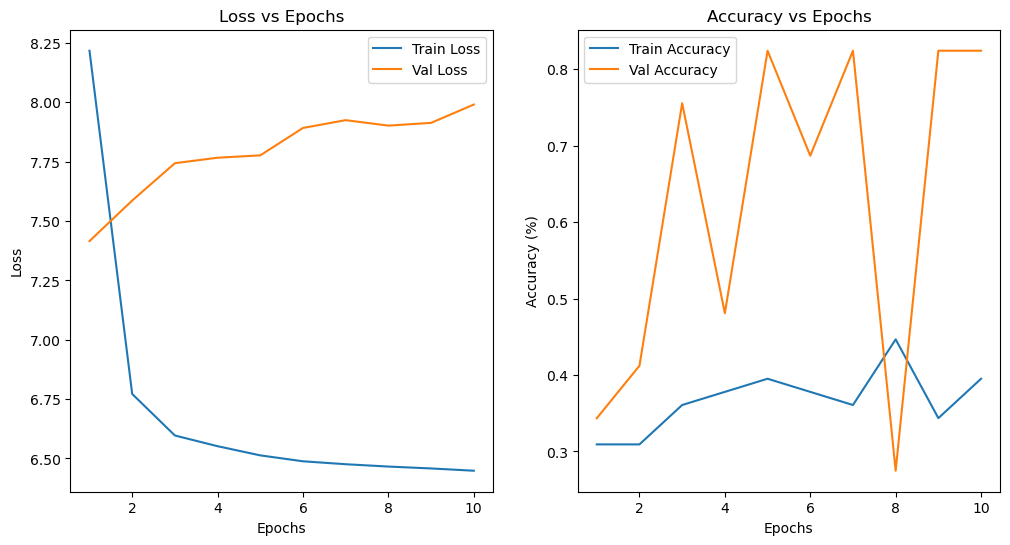

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.subplot(122)
plt.plot(range(1, epochs+1), train_accs, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accs, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

In [9]:
# Первый эксперимент: случайное сэмплирование
random_train_losses, random_val_losses = [], []
random_train_accs, random_val_accs = [], []

for epoch in range(epochs):
    print(f"\nRandom Sampling Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, shuffled_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, shuffled_val_loader, criterion, device)
    random_train_losses.append(train_loss)
    random_train_accs.append(train_acc)
    random_val_losses.append(val_loss)
    random_val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Второй эксперимент: curriculum learning
curriculum_train_losses, curriculum_val_losses = [], []
curriculum_train_accs, curriculum_val_accs = [], []

for epoch in range(epochs):
    print(f"\nCurriculum Learning Epoch {epoch+1}/{epochs}")
    train_loss, train_acc = train_epoch(model, curriculum_train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, curriculum_val_loader, criterion, device)
    curriculum_train_losses.append(train_loss)
    curriculum_train_accs.append(train_acc)
    curriculum_val_losses.append(val_loss)
    curriculum_val_accs.append(val_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Визуализация результатов обоих экспериментов
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(range(1, epochs+1), random_train_losses, label='Random Train Loss')
plt.plot(range(1, epochs+1), random_val_losses, label='Random Val Loss')
plt.plot(range(1, epochs+1), curriculum_train_losses, label='Curriculum Train Loss')
plt.plot(range(1, epochs+1), curriculum_val_losses, label='Curriculum Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison')

plt.subplot(122)
plt.plot(range(1, epochs+1), random_train_accs, label='Random Train Accuracy')
plt.plot(range(1, epochs+1), random_val_accs, label='Random Val Accuracy')
plt.plot(range(1, epochs+1), curriculum_train_accs, label='Curriculum Train Accuracy')
plt.plot(range(1, epochs+1), curriculum_val_accs, label='Curriculum Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Comparison')
plt.show()


Random Sampling Epoch 1/10


NameError: name 'shuffled_train_loader' is not defined